In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### Data prep

In [3]:
y = df['Outcome']
X = df.drop('Outcome',axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3, random_state=42)

from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

### Hyperparameter optimisation

In [11]:
from sklearn.svm import SVC
model = SVC(max_iter=100000,probability=True)

In [13]:
[10**i for i in range(-3,5)]

[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C':[10**i for i in range(-3,5)]
              ,'gamma':[10**i for i in range(-7,3)]
             }

opt_model = GridSearchCV(model,param_grid,cv=10,scoring='roc_auc'
                         ,n_jobs=-1,return_train_score=True)
opt_model.fit(X_train,y_train)
best_model = opt_model.best_estimator_

opt_model.best_params_

//anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 10, 'gamma': 0.01}

[[127  24]
 [ 31  49]]
Predicted negative: 158
Predicted positive: 73
Accuracy: 76.19 
ROC AUC: 81.07 


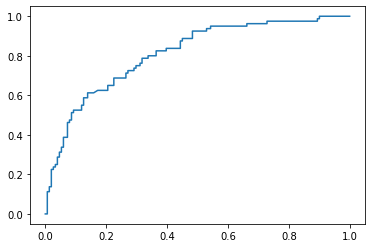

In [14]:
from sklearn.metrics import roc_curve,auc,accuracy_score,confusion_matrix

probas = best_model.predict_proba(X_test)[:,1]
preds = best_model.predict(X_test)

fpr,tpr,thr = roc_curve(y_test,probas)
plt.plot(fpr,tpr)

print(confusion_matrix(y_test,preds))

print('Predicted negative:',(preds==0).sum())
print('Predicted positive:',(preds==1).sum())

print('Accuracy: %.2f '%(accuracy_score(y_test,preds)*100))
print('ROC AUC: %.2f '%(auc(fpr,tpr)*100))

In [ ]:
sv = best_model.support_vectors_
sv.shape,X.shape,sv

### Sanity check

In [15]:
res = pd.DataFrame(opt_model.cv_results_)
varlst = ['mean_train_score','mean_test_score','std_train_score','std_test_score']
res = pd.merge(res[varlst],pd.DataFrame(opt_model.cv_results_['params']),left_index=True,right_index=True)

In [16]:
res

,mean_train_score,mean_test_score,std_train_score,std_test_score,C,gamma
0,0.838030,0.831397,7.131430e-03,0.049611,0.001,1.000000e-07
1,0.837606,0.828758,5.476680e-03,0.051973,0.001,1.000000e-06
2,0.838757,0.829975,7.001557e-03,0.051741,0.001,1.000000e-05
3,0.838357,0.831217,5.801978e-03,0.050477,0.001,1.000000e-04
4,0.838972,0.828154,7.275207e-03,0.050856,0.001,1.000000e-03
...,...,...,...,...,...,...
75,0.945033,0.761856,4.569685e-03,0.055086,10000.000,1.000000e-02
76,1.000000,0.732558,0.000000e+00,0.025093,10000.000,1.000000e-01
77,1.000000,0.749018,0.000000e+00,0.060819,10000.000,1.000000e+00
78,1.000000,0.737990,0.000000e+00,0.059593,10000.000,1.000000e+01


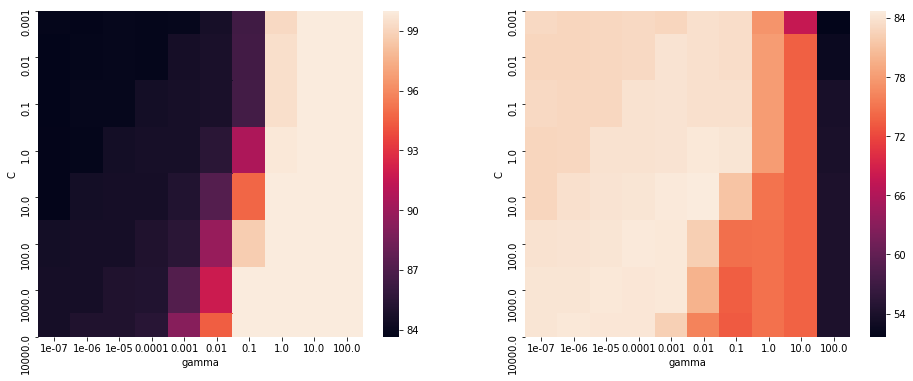

In [17]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
sns.heatmap(pd.pivot_table(res,index='C',columns='gamma',values='mean_train_score')*100)
plt.subplot(1,2,2)
sns.heatmap(pd.pivot_table(res,index='C',columns='gamma',values='mean_test_score')*100);

#### Single model

In [6]:
from sklearn.svm import SVC
model = SVC(gamma='auto',probability=True)

In [7]:
model.fit(X_train,y_train)
probas = model.predict_proba(X_test)[:,1]
preds = model.predict(X_test)

[[125  26]
 [ 33  47]]
Predicted negative: 158
Predicted positive: 73
Accuracy: 74.46 
ROC AUC: 79.74 


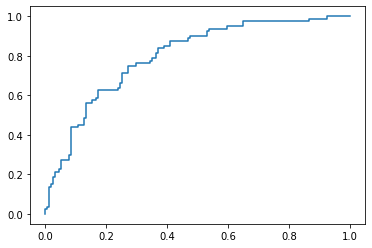

In [8]:
from sklearn.metrics import roc_curve,auc,accuracy_score,confusion_matrix
fpr,tpr, thrsh = roc_curve(y_test,probas)
plt.plot(fpr,tpr)
print(confusion_matrix(y_test,preds))

print('Predicted negative:',(preds==0).sum())
print('Predicted positive:',(preds==1).sum())

print('Accuracy: %.2f '%(accuracy_score(y_test,preds)*100))
print('ROC AUC: %.2f '%(auc(fpr,tpr)*100))

In [10]:
sv = model.support_vectors_
sv.shape,X_train.shape,sv

((307, 8),
 (537, 8),
 array([[ 0.08397217,  0.31417602, -0.09322566, ...,  0.14760887,
         -0.90681191, -0.43466673],
        [-0.8362943 , -0.5524449 , -2.19528409, ...,  1.48664968,
         -0.83951493, -0.00638043],
        [-0.52953881, -1.2024106 , -0.97830289, ..., -0.45627228,
          3.5962336 , -0.6916385 ],
        ...,
        [ 2.23126062,  0.53083125,  0.2386783 , ...,  0.54144441,
          0.25479242,  1.44979298],
        [ 1.92450513, -0.6143464 ,  0.90248622, ...,  1.78859026,
          1.94892066,  0.42190587],
        [-1.14304979,  0.62368349, -3.8548039 , ...,  1.36849903,
         -0.77514391, -0.34900947]]))